In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [12]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [4]:
import pickle
import itertools
import math
import random
import pandas as pd
import numpy as np
import networkx as nx

from datetime import date

In [5]:
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

In [6]:
df_air = pd.read_pickle('../data/networks/US_air_1990_2018.pkl')
nodes = set(df_air.source.unique())|set(df_air.target.unique())
df_air = df_air[df_air.source != df_air.target]
year = list(df_air.index.get_level_values(0).unique())
month = list(df_air.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
#        if y != 2018 or m != 12:
        df = df_air.loc[y,m]
        date_air.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df_air.loc[y,m], edge_attr=True)
        G.add_nodes_from(nodes)
        graphs_air.append(G)
        

n = date_air.index(date(2004,1,1))
graphs_air = graphs_air[n:]
date_air =  date_air[n:]

del df_air

In [7]:
import datetime
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

In [8]:
import glob, os

In [9]:
df = pd.DataFrame()
files = glob.glob('../simulation4/results/model_graphs_gamma*_Nend2000*.pickle.dat') \
+ glob.glob('../simulation4/results0/model_graphs_gamma*_Nend2000*.pickle.dat')
time,Nedges,gamma = [],[],[]
for f in files:
    graphs_prediction = pickle.load(open(f,'rb'))
    g = f.strip('.pickle.dat').split('_')[-2].strip('gamma')
    N = len(graphs_prediction)
#     if True:
    if g in ['0.01','0.02','0.04']:#['0.001','0.005','0.01','0.05','0.1','0.5','1','5']:
        time += [add_months(date_air[-1],j) for j in range(N)]
        Nedges += [G.number_of_edges() for G in graphs_prediction]
        gamma += [g] * N
df['time'] = time
df['Nedges'] = Nedges
df['$\gamma$'] = gamma

In [10]:
# df = df.astype({'$\gamma$': 'float'})
# data = df[df['$\gamma$']>=0.008]
# data = data[data['$\gamma$']<1]
data=df
data.head()

,time,Nedges,$\gamma$
0,2018-12-01,6016,0.01
1,2019-01-01,5977,0.01
2,2019-02-01,5938,0.01
3,2019-03-01,5899,0.01
4,2019-04-01,5861,0.01


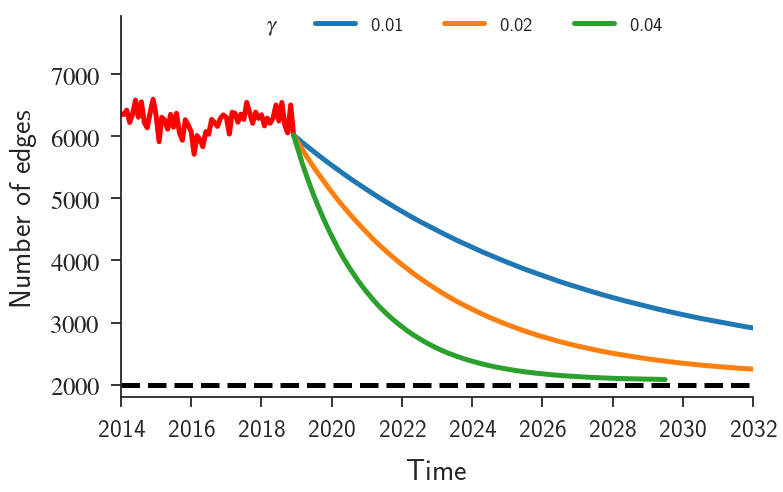

In [13]:
colors = sns.color_palette(None, data['$\gamma$'].nunique())
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[G.number_of_edges() for G in graphs_air],c='r')
g = sns.lineplot(x="time", y="Nedges",hue='$\gamma$',palette=colors, legend = 'full', 
             ci=95,n_boot=100,data=data,ax=ax)
plt.xlabel('Time')
plt.ylabel("Number of edges")
plt.axhline(y=2000,linestyle='--',c='black')
plt.xlim(date(2014,1,1),date(2032,1,1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=False, shadow=False,frameon=False)
custom_frame(ax)
plt.savefig('../Figs/Fig.5A_2000.pdf',transparent=True)
plt.show()

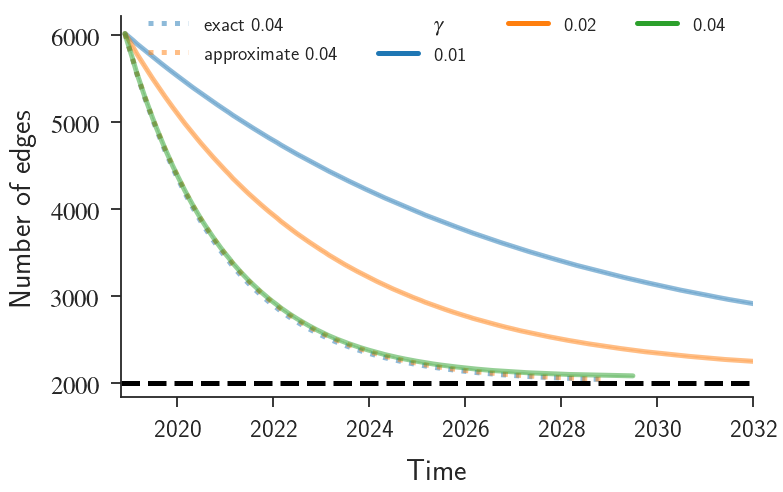

In [12]:
N0=graphs_air[-1].number_of_edges()
Nf=2000
def dn1(Nm,gamma):
    return int(gamma*(Nm-Nf))
def dn2(Nm,gamma):
    return int((1-np.exp(-gamma))*(Nm-Nf))

y1=[N0]
y2=[N0]
x = [date_air[-1]]
gamma=0.04
for i in range(120):
    y1.append(y1[-1]-dn1(y1[-1],gamma))
    y2.append(y2[-1]-dn2(y2[-1],gamma))
    x.append(add_months(date_air[-1],i+1))

colors = sns.color_palette(None, data['$\gamma$'].nunique())
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(x,y1,label='exact 0.04',alpha=0.5,linestyle='dotted')
plt.plot(x,y2,label='approximate 0.04',alpha=0.5,linestyle='dotted')
# plt.plot(date_air,[G.number_of_edges() for G in graphs_air],c='r')
g = sns.lineplot(x="time", y="Nedges",hue='$\gamma$',palette=colors, legend = 'full', 
             ci=95,n_boot=100,data=data,ax=ax,alpha=0.5)
plt.xlabel('Time')
plt.ylabel("Number of edges")
plt.axhline(y=2000,linestyle='--',c='black')
plt.xlim(date(2018,11,1),date(2032,1,1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=False, shadow=False,frameon=False)
custom_frame(ax)
plt.show()    

In [26]:
import collections

from scipy.stats import sem, t
from scipy import mean

def condition_filter(edge):
    a,b = edge
    return ('ak'!=a[-2::] and 'ak'!=b[-2::] and 'hi'!=a[-2::] and 'hi'!=b[-2::] and 'tt'!=a[-2::] and 'tt'!=b[-2::])

def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(len(mean)), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    ax.plot(mean, color_mean)
    
def get_survival_time(gamma,N_end):
    
    G = pickle.load(open(f'../simulation4/results/model_graphs_gamma{gamma}_Nend{N_end}0.pickle.dat','rb'))[0]
    edges_time = dict((edge,[]) for edge in list(G.edges()) if condition_filter(edge))
    files = glob.glob(f'../simulation4/results/model_graphs_gamma{gamma}_Nend{N_end}*.pickle.dat') + \
    glob.glob(f'../simulation4/results4/model_graphs_gamma{gamma}_Nend{N_end}*.pickle.dat')
    for f in files:
        graphs = pickle.load(open(f,'rb'))
        for edge in list(G.edges()):
            if condition_filter(edge):
                a = (sum([g.has_edge(*edge) for g in graphs])-1)/12
                edges_time[edge].append(a) 
            
    G = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}0.pickle.dat','rb'))[0]
    edges_time_null = dict((edge,[]) for edge in list(G.edges()))
    files = glob.glob(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}*.pickle.dat')+ \
    glob.glob(f'../simulation4/results4/model_graphs_null_gamma{gamma}_Nend{N_end}*.pickle.dat')    
    for f in files:
        graphs = pickle.load(open(f,'rb'))
        for edge in list(G.edges()):
            if condition_filter(edge):
                a = (sum([g.has_edge(*edge) for g in graphs])-1)/12
                edges_time_null[edge].append(a) 
    
    confidence = 0.95
    x,y_mean,y_up,y_low = [],[],[],[]
    for e,v in edges_time.items():
        x.append(e)
        n=len(v)
        std_err = sem(v)
        m = np.mean(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean.append(m)
        y_up.append(m+h)
        y_low.append(m-h)
    
    x = [i for _,i in sorted(zip(y_mean,x))]
    y_up = [i for _,i in sorted(zip(y_mean,y_up))]
    y_low = [i for _,i in sorted(zip(y_mean,y_low))]
    y_mean = sorted(y_mean)
    
#     y_mean_null,y_up_null,y_low_null = [],[],[]
#     for e in x:
#         v=edges_time_null[e]
#         std_err = sem(v)
#         m = np.mean(v)
#         h = std_err * t.ppf((1 + confidence) / 2, n - 1)
#         y_mean_null.append(m)
#         y_up_null.append(m+h)
#         y_low_null.append(m-h)

    confidence = 0.95
    x_null,y_mean_null,y_up_null,y_low_null = [],[],[],[]
    for e,v in edges_time_null.items():
        n=len(v)
        x_null.append(e)
        std_err = sem(v)
        m = np.mean(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean_null.append(m)
        y_up_null.append(m+h)
        y_low_null.append(m-h)
        
    x_null = [i for _,i in sorted(zip(y_mean_null,x_null))]
    y_up_null = [i for _,i in sorted(zip(y_mean_null,y_up_null))]
    y_low_null = [i for _,i in sorted(zip(y_mean_null,y_low_null))]
    y_mean_null = sorted(y_mean_null)
    
    return(x,y_mean,y_up,y_low,x_null,y_mean_null,y_up_null,y_low_null)    

def plot_survival_time(gamma,N_end,data,ax,model=True):
    if model:
        x,y_mean,y_up,y_low=data[0:4]
        title = f'Model with $N =$ {N_end}, $\gamma =$ {gamma}'
        path = f'../figures//Fig5c_model_survival_exponential_Nend{N_end}_gamma{gamma}.pdf'
    else:
        x,y_mean,y_up,y_low=data[4::]
        title = f'Null with  $N =$ {N_end}, $\gamma =$ {gamma}'
        path = f'../figures//Fig5c_null_survival_exponential_Nend{N_end}_gamma{gamma}.pdf'
    
#     fig,ax=plt.subplots(figsize=(xs*1.5,ys*1.5))
    plot_mean_and_CI(y_mean, y_up, y_low, color_mean='k', color_shading='grey')
    text_size =25
    index = 3002#x.index(('seattle_wa', 'santa_rosa_ca'))
    ax.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=text_size,
                xytext=(-65,-100), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))


    index = 1 #x.index(('san_diego_ca', 'mountain_view_ca'))
    ax.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=text_size,
                xytext=(50,0), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))





    index = x.index(('new_york_ny','chicago_il'))
    ax.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=text_size,
                xytext=(-100,-200), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))
    
    show_edges = sorted([(i,j) for i,j in zip(edges,pred_prob_start) if center in i],key=lambda x: x[1],reverse=True)
    show_edges_t = show_edges[0:1]+show_edges[-1:]
    for e,j in show_edges_t:
        index = x.index(e)
        plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
        ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=text_size,
                xytext=(-60,60), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))
    plt.title(title)
    plt.xlabel('Edge importance')
    plt.ylabel('Survival time (month)')
    custom_frame(ax)


In [27]:
gamma =0.01
N_end=2000
G_start = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}21.pickle.dat','rb'))[0]
G_end = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}21.pickle.dat','rb'))[12*12]
add_time = len(pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}21.pickle.dat','rb')))

In [28]:
# fig = plt.figure(figsize=(xs*1.5,0.5*ys),constrained_layout=False)
# gs = fig.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.48, wspace=0,hspace=0.3)

# #---------------
# ax2 = fig.add_subplot(gs[0, 0])
# ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes,
#       fontsize=30, fontweight='bold', va='top', ha='right')
# ax2.set_title(f'{date_air[-1]}')
# center = 'burlington_vt'
# show_edges = [i for i in list(G_start.edges()) if center in i]
# G = nx.Graph()
# G.add_edges_from([i for i in show_edges])
# pos = nx.circular_layout(G)
# # pos = dict([(i[0][0],j) if i[0][1]==center else (i[0][1],j) for i,j in zip(show_edges,list(cor.values()))])
# pos[center] = np.array([0,0])
# label = dict([(i,make_node_name(i).split(',')[0]) if i==center else (i,make_node_name(i).split(',')[0]) for i in list(pos.keys())])
# label[center] = make_node_name(center).split(',')[0]
# nx.set_node_attributes(G, dict([(i,j[0]) for i,j in pos.items()]), 'x')
# nx.set_node_attributes(G, dict([(i,j[1]) for i,j in pos.items()]), 'y')
# nx.draw(G,pos=pos,node_size =1000,font_size =15,labels=label,node_color='#9ecae1',ax=ax2)
# l,r = ax2.get_xlim()
# ax2.set_xlim(l-0.3,r+0.3)


# ax3 = fig.add_subplot(gs[0, 1])
# ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes,
#       fontsize=30, fontweight='bold', va='top', ha='right')
# ax3.set_title(f'{add_months(date_air[-1],10*12)}')
# show_edges = [i for i in show_edges if G_end.has_edge(*i)]
# G = nx.Graph()
# G.add_edges_from([i for i in show_edges])
# label = dict([(i,make_node_name(i).split(',')[0]) if i==center else (i,make_node_name(i).split(',')[0]) for i in list(pos.keys()) if i in list(G.nodes())]) 
# label[center] = make_node_name(center).split(',')[0]
# nx.draw(G,pos=pos,node_size =1000,labels=label,font_size =18,node_color='#9ecae1',ax=ax3)
# l,r = ax3.get_xlim()
# ax3.set_xlim(l-0.3,r+0.3)
# plt.show()

In [29]:
# # import essential packages
# import cartopy.crs as ccrs
# import cartopy as cartopy
# import cartopy.io.shapereader as shpreader
# import cartopy.crs as ccrs
# from cartopy.io import shapereader
# from matplotlib.lines import Line2D




# n=11
# gamma =0.01
# N_end=2000
# G_start = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}{n}.pickle.dat','rb'))[0]
# G_end = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}{n}.pickle.dat','rb'))[12*12]
# add_time = len(pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}{n}.pickle.dat','rb')))

# #function to convert node name to readable form
# def make_node_name(node):
#     node = node.title()
#     text = node.split('_')    
#     if len(text)<3:
#         return ','.join([text[0],text[1].upper()])
#     else:
#         city = ' '.join(text[0:-1])
#         state = text[-1]
#         state = state.upper()
#         return ','.join([city,state])

# #nodes position information
# pos = pd.read_pickle('../data/US_air_geo_information.pkl')

# # center = 'burlington_vt'
# center ='chicago_il'
# show_edges = [i for i in list(G_start.edges()) if center in i]
# show_edges = [edge for edge in show_edges if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
# show_edges = [edge for edge in show_edges if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]

# label_edges = [('chicago_il', 'boston_ma'),
#                ('chicago_il', 'dayton_oh'),
#                ('chicago_il', 'sioux_city_ia'),
#               ('chicago_il', 'appleton_wi'),
#               ('chicago_il', 'fayetteville_ar'),
#               ('chicago_il', 'burbank_ca'),
#               ('chicago_il', 'seattle_wa'),
#               ('chicago_il', 'miami_fl')]

# G = nx.Graph()
# G.add_edges_from([i for i in show_edges])
# red_edges = [i for i in show_edges if not G_end.has_edge(*i)]
# black_edges = [i for i in show_edges if G_end.has_edge(*i)]

# red_label_edges = [e for e in label_edges if e in red_edges]
# black_label_edges = [e for e in label_edges if e in black_edges]
# red_label = dict([(i,make_node_name(i).split(',')[0]) for _,i in red_label_edges]) 
# #red_label[center] = make_node_name(center).split(',')[0]
# black_label = dict([(i,make_node_name(i).split(',')[0]) for _,i in black_label_edges]) 
# #black_label[center] = make_node_name(center).split(',')[0]


# # border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
# border = [-119,-74,23,50]
# central_lon = np.mean(border[:2])
# central_lat = np.mean(border[2:])


# fig = plt.figure(figsize=(xs,ys),frameon=False)
# ax = fig.add_subplot(1,1,1,projection=ccrs.AlbersEqualArea(central_lon, central_lat))

# shapename = 'admin_1_states_provinces_lakes_shp'
# states_shp = shpreader.natural_earth(resolution='110m',
#                                      category='cultural', name=shapename)
# shp = shapereader.Reader(states_shp)
# ax.background_patch.set_visible(False)
# ax.outline_patch.set_visible(False)
# for record, state in zip(shp.records(), shp.geometries()):
#     name = record.attributes['name']
#     facecolor = '#f0f0f0'
#     ax.add_geometries([state], ccrs.PlateCarree(),
#                       facecolor=facecolor, edgecolor='none',zorder=-1)
# ax.set_extent(border)
# # ax.set_xlim(-125,-67)
# # ax.set_ylim(20,50)
# # draw edges
# draw(G,
#         pos = pos,
#         width= 1,
#         alpha= 0.15,
#         node_size = 0,
#         edgelist= black_edges,
#         edge_color = 'black',
#         style = 'solid')

# draw(G,
#     pos = pos,
#     width= 1,
#     alpha= 0.15,
#     node_size = 0,
#     edgelist= red_edges,
#     edge_color = 'red',
#     style = 'dashed')

# ###labels
# draw(G,
#         pos = pos,
#         width= 1,
#         alpha= 1,
#         node_size = 0,
#         edgelist =  black_label_edges,
#          labels= black_label,
#          font_color = 'black',
#         edge_color = 'black',
#         style = 'solid',font_size=25)

# draw(G,
#     pos = pos,
#     width= 1,
#     alpha= 1,
#     node_size = 0,
#      edgelist =  red_label_edges,
#      labels= red_label,
#     edge_color = 'red',
#      font_color = 'red',
#     style = 'dashed',font_size=25)

# # draw nodes
# draw(G,
#     pos = pos,
#     node_color = '#377eb8',
#     width= 0,
#     alpha= 0.2,
#     node_size = np.array(list(dict(G_end.degree()).values()))*1)

# ax.background_patch.set_visible(False)
# ax.outline_patch.set_visible(False)
# #     ax.set_title('Air, US (Jan. 2014)')
# plt.savefig('../Figs/Fig.5C_v2.png',bbox_inches='tight',dpi=200,transparent=True)
# plt.show()

In [30]:
data_1 = get_survival_time(gamma,N_end)

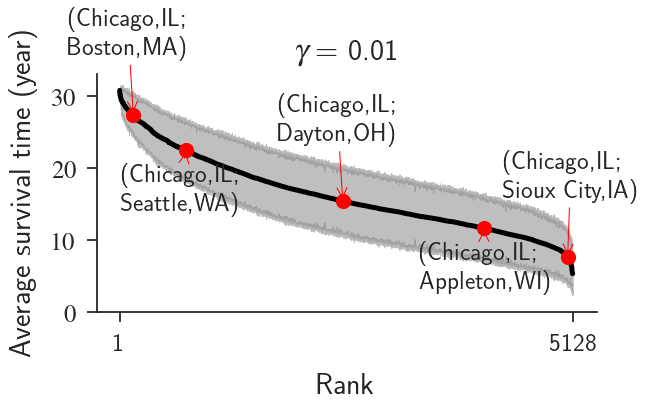

In [50]:
import collections

from scipy.stats import sem, t
from scipy import mean

def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(np.arange(len(mean))+1, ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(np.arange(len(mean))+1,mean, color_mean)


x,y_mean,y_up,y_low=data_1[0:4]

fig,ax=plt.subplots(figsize=(xs*0.8,ys*0.8))
plot_mean_and_CI(y_mean, y_up, y_low, color_mean='k', color_shading='grey')
text_size = 25
temp = [1,-1,1,-1,1]

label_edges = [('chicago_il', 'sioux_city_ia'),
                ('chicago_il', 'appleton_wi'),
               ('chicago_il', 'dayton_oh'),
              ('chicago_il', 'seattle_wa'),
                ('chicago_il', 'boston_ma')]

for e,n in zip(label_edges,temp):
    index = x.index(e)
    plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
            xy=(index, y_mean[index]), xycoords='data',size=text_size,
            xytext=(-65,n*60), textcoords='offset pixels',
            arrowprops=dict(arrowstyle="->",color='r'))

gamma = 0.01
plt.title(f'$\gamma =$ {gamma}')
plt.xlabel('Rank')
plt.ylabel('Average survival time (year)')
plt.xticks([len(x),1],[1,len(x)])
plt.yticks([0,10,20,30])
ax.invert_xaxis()
custom_frame(ax)
plt.tight_layout()
plt.savefig('../Figs/Fig.5B_v3_NoAK.pdf',transparent=True)
plt.show()

In [17]:
from numbers import Number
import networkx as nx
from networkx.utils import is_string_like
from networkx.drawing.layout import shell_layout, \
    circular_layout, kamada_kawai_layout, spectral_layout, \
    spring_layout, random_layout, planar_layout

__all__ = ['draw',
           'draw_networkx',
           'draw_networkx_nodes',
           'draw_networkx_edges',
           'draw_networkx_labels',
           'draw_networkx_edge_labels',
           'draw_circular',
           'draw_kamada_kawai',
           'draw_random',
           'draw_spectral',
           'draw_spring',
           'draw_planar',
           'draw_shell']


def draw(G, pos=None, ax=None, **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        cf = plt.gcf()
    else:
        cf = ax.get_figure()
    cf.set_facecolor('w')
    if ax is None:
        if cf._axstack() is None:
            ax = cf.add_axes((0, 0, 1, 1))
        else:
            ax = cf.gca()

    if 'with_labels' not in kwds:
        kwds['with_labels'] = 'labels' in kwds

    draw_networkx(G, pos=pos, ax=ax, **kwds)
    ax.set_axis_off()
    plt.draw_if_interactive()
    return



def draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if pos is None:
        pos = nx.drawing.spring_layout(G)  # default to spring layout

    node_collection = draw_networkx_nodes(G, pos, **kwds)
    edge_collection = draw_networkx_edges(G, pos, arrows=arrows, **kwds)
    if with_labels:
        draw_networkx_labels(G, pos, **kwds)
    plt.draw_if_interactive()



def draw_networkx_nodes(G, pos,
                        nodelist=None,
                        node_size=300,
                        node_color='#1f78b4',
                        node_shape='o',
                        alpha=None,
                        cmap=None,
                        vmin=None,
                        vmax=None,
                        ax=None,
                        linewidths=None,
                        edgecolors=None,
                        label=None,
                        **kwds):

    from collections.abc import Iterable
    try:
        import matplotlib.pyplot as plt
        import numpy as np
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if nodelist is None:
        nodelist = list(G)

    if len(nodelist) == 0:  # empty nodelist, no drawing
        return

    try:
        xy = np.asarray([pos[v] for v in nodelist])
    except KeyError as e:
        raise nx.NetworkXError('Node %s has no position.' % e)
    except ValueError:
        raise nx.NetworkXError('Bad value in node positions.')

    if isinstance(alpha, Iterable):
        node_color = apply_alpha(node_color, alpha, nodelist, cmap, vmin, vmax)
        alpha = None

    node_collection = ax.scatter(xy[:, 0], xy[:, 1],
                                 s=node_size,
                                 c=node_color,
                                 marker=node_shape,
                                 cmap=cmap,
                                 vmin=vmin,
                                 vmax=vmax,
                                 alpha=alpha,
                                 linewidths=linewidths,
                                 edgecolors=edgecolors,
                                 label=label,transform=ccrs.Geodetic())
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    node_collection.set_zorder(2)
    return node_collection



def draw_networkx_edges(G, pos,
                        edgelist=None,
                        width=1.0,
                        edge_color='k',
                        style='solid',
                        alpha=None,
                        arrowstyle='-|>',
                        arrowsize=10,
                        edge_cmap=None,
                        edge_vmin=None,
                        edge_vmax=None,
                        ax=None,
                        arrows=True,
                        label=None,
                        node_size=300,
                        nodelist=None,
                        node_shape="o",
                        connectionstyle=None,
                        min_source_margin=0,
                        min_target_margin=0,
                        **kwds):
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.colors import colorConverter, Colormap, Normalize
        from matplotlib.collections import LineCollection
        from matplotlib.patches import FancyArrowPatch
        import numpy as np
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if edgelist is None:
        edgelist = list(G.edges())

    if not edgelist or len(edgelist) == 0:  # no edges!
        return None

    if nodelist is None:
        nodelist = list(G.nodes())

    # FancyArrowPatch handles color=None different from LineCollection
    if edge_color is None:
        edge_color = 'k'

    # set edge positions
    edge_pos = np.asarray([(pos[e[0]], pos[e[1]]) for e in edgelist])

    # Check if edge_color is an array of floats and map to edge_cmap.
    # This is the only case handled differently from matplotlib
    if np.iterable(edge_color) and (len(edge_color) == len(edge_pos)) \
            and np.alltrue([isinstance(c, Number) for c in edge_color]):
        if edge_cmap is not None:
            assert(isinstance(edge_cmap, Colormap))
        else:
            edge_cmap = plt.get_cmap()
        if edge_vmin is None:
            edge_vmin = min(edge_color)
        if edge_vmax is None:
            edge_vmax = max(edge_color)
        color_normal = Normalize(vmin=edge_vmin, vmax=edge_vmax)
        edge_color = [edge_cmap(color_normal(e)) for e in edge_color]

    if (not G.is_directed() or not arrows):
        edge_collection = LineCollection(edge_pos,
                                         colors=edge_color,
                                         linewidths=width,
                                         antialiaseds=(1,),
                                         linestyle=style,
                                         transOffset=ax.transData,
                                         alpha=alpha,transform=ccrs.Geodetic()
                                         )

        edge_collection.set_zorder(1)  # edges go behind nodes
        edge_collection.set_label(label)
        ax.add_collection(edge_collection)

        return edge_collection

    arrow_collection = None

    if G.is_directed() and arrows:
        # Note: Waiting for someone to implement arrow to intersection with
        # marker.  Meanwhile, this works well for polygons with more than 4
        # sides and circle.

        def to_marker_edge(marker_size, marker):
            if marker in "s^>v<d":  # `large` markers need extra space
                return np.sqrt(2 * marker_size) / 2
            else:
                return np.sqrt(marker_size) / 2

        # Draw arrows with `matplotlib.patches.FancyarrowPatch`
        arrow_collection = []
        mutation_scale = arrowsize  # scale factor of arrow head

        # FancyArrowPatch doesn't handle color strings
        arrow_colors = colorConverter.to_rgba_array(edge_color, alpha)
        for i, (src, dst) in enumerate(edge_pos):
            x1, y1 = src
            x2, y2 = dst
            shrink_source = 0  # space from source to tail
            shrink_target = 0  # space from  head to target
            if np.iterable(node_size):  # many node sizes
                src_node, dst_node = edgelist[i][:2]
                index_node = nodelist.index(dst_node)
                marker_size = node_size[index_node]
                shrink_target = to_marker_edge(marker_size, node_shape)
            else:
                shrink_target = to_marker_edge(node_size, node_shape)

            if shrink_source < min_source_margin:
                shrink_source = min_source_margin

            if shrink_target < min_target_margin:
                shrink_target = min_target_margin

            if len(arrow_colors) == len(edge_pos):
                arrow_color = arrow_colors[i]
            elif len(arrow_colors) == 1:
                arrow_color = arrow_colors[0]
            else:  # Cycle through colors
                arrow_color = arrow_colors[i % len(arrow_colors)]

            if np.iterable(width):
                if len(width) == len(edge_pos):
                    line_width = width[i]
                else:
                    line_width = width[i % len(width)]
            else:
                line_width = width

            arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                    arrowstyle=arrowstyle,
                                    shrinkA=shrink_source,
                                    shrinkB=shrink_target,
                                    mutation_scale=mutation_scale,
                                    color=arrow_color,
                                    linewidth=line_width,
                                    connectionstyle=connectionstyle,
                                    zorder=1)  # arrows go behind nodes

            # There seems to be a bug in matplotlib to make collections of
            # FancyArrowPatch instances. Until fixed, the patches are added
            # individually to the axes instance.
            arrow_collection.append(arrow)
            ax.add_patch(arrow)

    # update view
    minx = np.amin(np.ravel(edge_pos[:, :, 0]))
    maxx = np.amax(np.ravel(edge_pos[:, :, 0]))
    miny = np.amin(np.ravel(edge_pos[:, :, 1]))
    maxy = np.amax(np.ravel(edge_pos[:, :, 1]))

    w = maxx - minx
    h = maxy - miny
    padx,  pady = 0.05 * w, 0.05 * h
    corners = (minx - padx, miny - pady), (maxx + padx, maxy + pady)
    ax.update_datalim(corners)
    ax.autoscale_view()

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    return arrow_collection



def draw_networkx_labels(G, pos,
                         labels=None,
                         font_size=12,
                         font_color='k',
                         font_family='sans-serif',
                         font_weight='normal',
                         alpha=None,
                         bbox=None,
                         ax=None,
                         **kwds):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = dict((n, n) for n in G.nodes())

    # set optional alignment
    horizontalalignment = kwds.get('horizontalalignment', 'center')
    verticalalignment = kwds.get('verticalalignment', 'center')

    text_items = {}  # there is no text collection so we'll fake one
    for n, label in labels.items():
        (x, y) = pos[n]
        if not is_string_like(label):
            label = str(label)  # this makes "1" and 1 labeled the same
        t = ax.text(x, y,
                    label,
                    size=font_size,
                    color=font_color,
                    family=font_family,
                    weight=font_weight,
                    alpha=alpha,
                    horizontalalignment=horizontalalignment,
                    verticalalignment=verticalalignment,
                    transform=ccrs.Geodetic(),
                    bbox=bbox,
                    clip_on=True,
                    )
        text_items[n] = t

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

    return text_items


In [36]:
# pd.DataFrame(data_1[0]).to_pickle('../data/ranked_edges.pkl')

In [37]:
distance = pd.read_pickle('../data/us_air_distance.pkl')
dict_dist = distance.set_index(['source','target']).to_dict()['distance']
dict_dist.update(distance.set_index(['target','source']).to_dict()['distance'])

In [38]:
import statsmodels.api as sm
import math
population = pd.read_pickle('../data/us_air_population_3.pkl').fillna(value=np.nan).to_dict()[0]
def plot_imp_vs_g(y_mean=y_mean,alpha=2,bins=1):
    x = []
    for e in data_1[0]:
        a,b = e
        if (a,b) in list(dict_dist.keys()):
            d = dict_dist[(a,b)]
        elif (b,a) in list(dict_dist.keys()):
            d = dict_dist[(b,a)]
        else:
            d = np.nan
        if a in list(population.keys()):
            pa = population[a]
        else:
            pa = np.nan
        if b in list(population.keys()):
            pb = population[b]
        else:
            pb = np.nan
        x.append(pa*pb/d**alpha)
        population_i.append(pa)
        population_j.append(pb)
    x = np.log(np.array(x))
    y = y_mean
#     y = np.array(y)
#     y = y[0:bins*(len(y)//bins)]
#     y = np.nanmean(y.reshape(-1, bins), axis=1)
    fit_df = pd.DataFrame({'X':[i for i,j in zip(x,y) if (math.isfinite(i)==True)],
    'Y':[j for i,j in zip(x,y) if (math.isfinite(i)==True)]})
    X = fit_df[['X']]
    X = sm.add_constant(X)
    Y = fit_df[['Y']]
    mod = sm.OLS(Y,X)
    res = mod.fit()
    beta = res.params['X']
    const = res.params['const']
    fit_x = np.linspace(min(x),max(x),10)
    fit_y = beta*fit_x+const
    fig,ax = plt.subplots(figsize=(xs*0.8,ys*0.8))
    plt.scatter(x,y,alpha=0.6)
    plt.plot(fit_x,fit_y,color='r',label=f'fitted: $Y={round(beta,4)} X+{round(const,2)}$')
    plt.xlabel('$N_i*N_j/r^2$ ($log_e$)')
    plt.ylabel('Average survival time (year)')
    plt.title(f'alpha={alpha}')
    custom_frame(ax)
    # plt.legend()
    plt.tight_layout()
#     plt.savefig('../Figs/Fig.5D_v2.pdf',transparent=True)
    plt.show()

In [40]:
ak_edges = []
for e in data_1[0]:
    a,b=e
    if 'ak'==a[-2::] or 'ak'==b[-2::] or 'hi'==a[-2::] or 'hi'==b[-2::] or 'tt'==a[-2::] or 'tt'==b[-2::]:
        ak_edges.append(e)
x_label,y_label = [],[]
for e in ak_edges:
    a,b = e
    if (a,b) in list(dict_dist.keys()):
        d = dict_dist[(a,b)]
    elif (b,a) in list(dict_dist.keys()):
        d = dict_dist[(b,a)]
    else:
        d = np.nan
    if a in list(population.keys()):
        pa = population[a]
    else:
        pa = np.nan
    if b in list(population.keys()):
        pb = population[b]
    else:
        pb = np.nan
    x_label.append(pa*pb/d**2)
    y_label.append(y_mean[data_1[0].index(e)])
x_label = np.log(np.array(x_label))
# x_label   

In [79]:
bins=1
x,y = [],[]
population_i,population_j,dist_ij = [],[],[]
for e,yi in zip(data_1[0],y_mean):
    a,b = e
    if 'ak'!=a[-2::] and 'ak'!=b[-2::] and 'hi'!=a[-2::] and 'hi'!=b[-2::] and 'tt'!=a[-2::] and 'tt'!=b[-2::]:
        if (a,b) in list(dict_dist.keys()):
            d = dict_dist[(a,b)]
        elif (b,a) in list(dict_dist.keys()):
            d = dict_dist[(b,a)]
        else:
            d = np.nan
        if a in list(population.keys()):
            pa = population[a]
        else:
            pa = np.nan
        if b in list(population.keys()):
            pb = population[b]
        else:
            pb = np.nan
        x.append(pa*pb/d**2)
        population_i.append(pa)
        population_j.append(pb)
        dist_ij.append(d)
        y.append(yi)
x = np.log(np.array(x))
# x = np.array(x)
#     y = np.array(y)
# x = x[0:bins*(len(x)//bins)]
# x = np.nanmean(x.reshape(-1, bins), axis=1)
y = np.array(y)
# print(x)

In [312]:
# temp_df = pd.DataFrame({'edge':data_1[0],'average_suvival_time':y_mean,'population_i':population_i,'population_j':population_j,'distance':dist_ij})#.to_pickle('../data/average_suvival_time_data.pkl')

In [105]:
fit_df = pd.DataFrame({'X':[i for i,j in zip(x,y) if (math.isfinite(i)==True)],
'Y':[j for i,j in zip(x,y) if (math.isfinite(i)==True)]})
X = fit_df[['X']]
X = sm.add_constant(X)
Y = fit_df[['Y']]
mod = sm.OLS(Y,X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     702.1
Date:                Tue, 08 Dec 2020   Prob (F-statistic):          5.50e-145
Time:                        11:30:16   Log-Likelihood:                -15164.
No. Observations:                5056   AIC:                         3.033e+04
Df Residuals:                    5054   BIC:                         3.034e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4253      0.378     17.004      0.0

In [106]:
res.conf_int()

,0,1
const,5.684543,7.166109
X,0.762308,0.884117


In [107]:
res.pvalues

const     4.223890e-63
X        5.504100e-145
dtype: float64

In [108]:
beta = res.params['X']
const = res.params['const']
fit_x = np.linspace(min(x),max(x),10)
fit_y = beta*fit_x+const

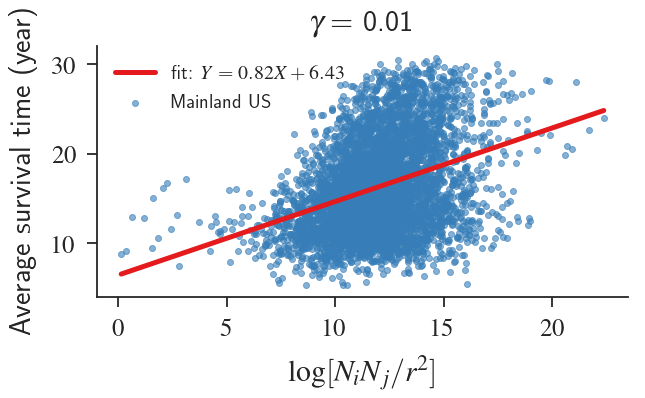

In [131]:
fig,ax = plt.subplots(figsize=(xs*0.8,ys*0.8))
plt.scatter(fit_df.X,fit_df.Y,color='#377eb8',alpha=0.6,label='Mainland US')
plt.plot(fit_x,fit_y,color='#e41a1c',label=f'fit: $Y={round(beta,2)} X+{round(const,2)}$')
# plt.scatter(x_label,y_label,color='#4daf4a',alpha=0.6,label='AK, HI, TT')
ax.set_xlabel(r'$\log [N_i N_j / r^2]$')
plt.ylabel('Average survival time (year)')
custom_frame(ax)
plt.title(f'$\gamma =$ {gamma}')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('../Figs/Fig.SI_5D.pdf',transparent=True)
plt.show()

In [87]:
from scipy.optimize import curve_fit
def func(x, a, c):
    return a*x + c
popt, pcov = curve_fit(func, fit_df[['X']].values.reshape(-1,), fit_df[['Y']].values.reshape(-1,))

In [88]:
popt

array([0.82321246, 6.42532619])

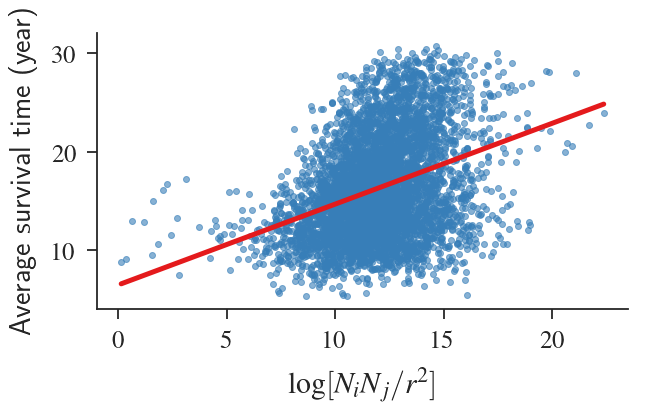

In [121]:
fig,ax = plt.subplots(figsize=(xs*0.8,ys*0.8))
plt.scatter(x,y,color='#377eb8',alpha=0.6)
plt.plot(fit_x,fit_y,color='#e41a1c')#,label=f'fitted: $Y={round(beta,4)} X+{round(const,2)}$')
# plt.scatter(x_label,y_label,color='#4daf4a',alpha=0.6,label='AK, HI, TT')
ax.set_xlabel(r'$\log [N_i N_j / r^2]$')
plt.ylabel('Average survival time (year)')
custom_frame(ax)
# plt.legend()
plt.tight_layout()
plt.savefig('../Figs/Fig.5D_v2NoAK.pdf',transparent=True)
plt.show()

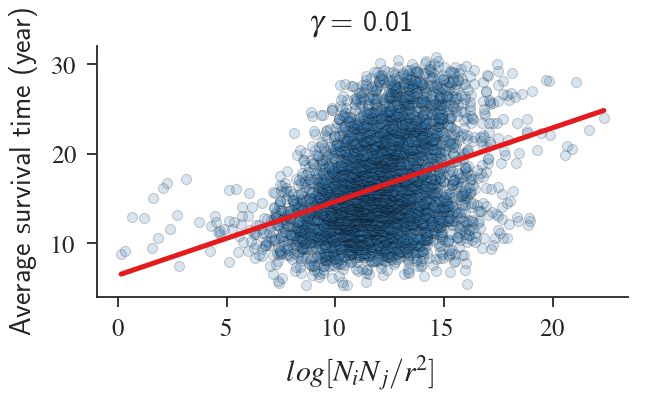

In [122]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(xs*0.8,ys*0.8))
plt.title(f'$\gamma =$ {gamma}')
ax.plot(x,y,'o',
        color='#377eb8',
        alpha=0.2,
        markersize=10,
        markeredgewidth=1.0, 
        markeredgecolor='k',
        rasterized=True,zorder=1)
ax.plot(fit_x,fit_y,color='#e41a1c',linewidth=5,zorder=2)
ax.plot(x_label,y_label,'o',
        color='#4daf4a',
        alpha=0.2,
        markersize=10,
        markeredgewidth=1.0, 
        markeredgecolor='k',
        rasterized=True,zorder=1)
ax.set_xlabel(r'$log [N_i N_j / r^2]$')
ax.set_ylabel(r'Average survival time (year)')
custom_frame(ax)
plt.tight_layout()
plt.savefig('../Figs/Fig.5D_v3AK.pdf',transparent=True)
plt.show()

In [119]:
!pwd

/home/weihua/Research/Link_Dynamics/notebooks


In [267]:
temp_df.head()
temp_df['g'] = np.log(temp_df.population_i*temp_df.population_j/temp_df.distance**2)

In [270]:
temp_df[temp_df.g<5]

,edge,average_suvival_time,population_i,population_j,distance,g
6,"(savoonga_ak, unalakleet_ak)",5.594444,671.0,688.0,297.0,1.655094
10,"(galena_ak, unalakleet_ak)",5.911111,470.0,688.0,130.0,2.951453
29,"(levelock_ak, igiugig_ak)",6.836111,69.0,50.0,37.0,0.924294
44,"(dillingham_ak, goodnews_bay_ak)",7.144444,2329.0,243.0,109.0,3.863560
58,"(south_bend_in, teterboro_nj)",7.461111,101168.0,67.0,640.0,2.806294
111,"(kahului_hi, teterboro_nj)",8.155556,26337.0,67.0,4907.0,-2.613413
158,"(nome_ak, russian_mission_ak)",8.516667,3598.0,312.0,229.0,3.063693
167,"(kahului_hi, eagle_co)",8.580556,26337.0,10266.0,3182.0,3.284792
198,"(savoonga_ak, teller_ak)",8.722222,671.0,229.0,164.0,1.742758
220,"(burbank_ca, teterboro_nj)",8.800000,103340.0,67.0,2449.0,0.143602


In [271]:
def winm(x, y, nw):
    xw = []
    yw = []
    step = (max(x) - min(x)) / nw
    lw = [min(x) + step * i for i in range(0, nw)]
    for i in range(0, len(lw) - 1):
        if len(y[x > lw[i]][x[x > lw[i]] < lw[i + 1]]) > 0:
            xw.append(np.mean(x[x > lw[i]][x[x > lw[i]] < lw[i + 1]]))
            yw.append(np.mean(y[x > lw[i]][x[x > lw[i]] < lw[i + 1]]))
    return (xw, yw)

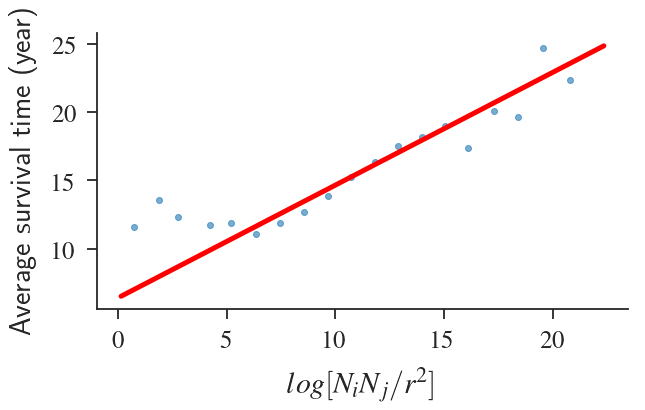

In [321]:
xw,yw = winm(x,y,20)
fig,ax = plt.subplots(figsize=(xs*0.8,ys*0.8))
plt.scatter(xw,yw,alpha=0.6)
plt.plot(fit_x,fit_y,color='r',label=f'fitted: $Y={round(beta,4)} X+{round(const,2)}$')
ax.set_xlabel(r'$log [N_i N_j / r^2]$')
plt.ylabel('Average survival time (year)')
custom_frame(ax)
# plt.legend()
plt.tight_layout()
# plt.savefig('../Figs/Fig.5D_v2.pdf',transparent=True)
plt.show()

In [73]:
y = np.array(x)
x = np.arange(len(x))

In [53]:
fit_df = pd.DataFrame({'X':[i for i,j in zip(x,y) if (math.isfinite(j)==True)],
'Y':[j for i,j in zip(x,y) if (math.isfinite(j)==True)]})
X = fit_df[['X']]
X = sm.add_constant(X)
Y = fit_df[['Y']]
mod = sm.OLS(Y,X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     484.4
Date:                Thu, 03 Dec 2020   Prob (F-statistic):          1.25e-102
Time:                        10:47:04   Log-Likelihood:                -12631.
No. Observations:                5093   AIC:                         2.527e+04
Df Residuals:                    5091   BIC:                         2.528e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6527      0.084    114.377      0.0

In [54]:
res.conf_int()

,0,1
const,9.487230,9.818125
X,0.000469,0.000561


In [55]:
res.pvalues

const     0.000000e+00
X        1.250646e-102
dtype: float64

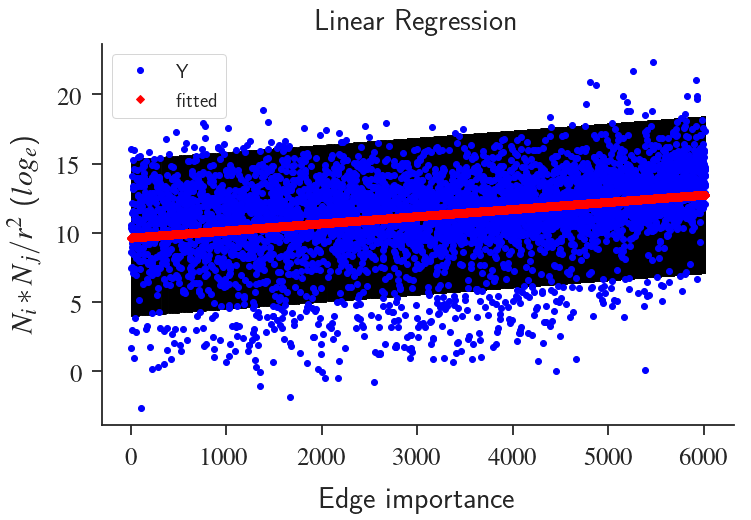

In [56]:
fig, ax = plt.subplots(figsize=figsize)
fig = sm.graphics.plot_fit(res, 1, ax=ax)
plt.xlabel('Edge importance')
plt.ylabel('$N_i*N_j/r^2$ ($log_e$)')
ax.set_title("Linear Regression")
custom_frame(ax)
plt.show()

In [57]:
beta = res.params['X']
const = res.params['const']
fit_x = np.linspace(min(x),max(x),10)
fit_y = beta*fit_x+const

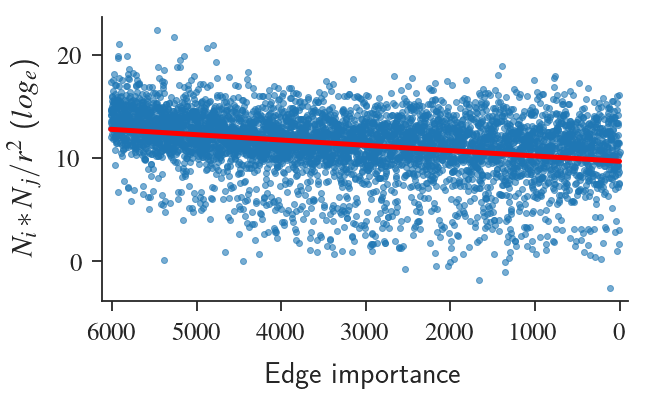

In [63]:
fig,ax = plt.subplots(figsize=(xs*0.8,ys*0.8))
plt.scatter(x,y,alpha=0.6)
plt.plot(fit_x,fit_y,color='r',label=f'fitted: $Y={round(beta,4)} X+{round(const,2)}$')
ax.set_xlim(len(x)+100,0-100)
plt.ylabel('$N_i*N_j/r^2$ ($log_e$)')
plt.xlabel('Edge importance')
custom_frame(ax)
# plt.legend()
plt.tight_layout()
plt.savefig('../Figs/Fig.5D_v1.pdf',transparent=True)
plt.show()

In [29]:
# plot_imp_vs_g(bins=1)

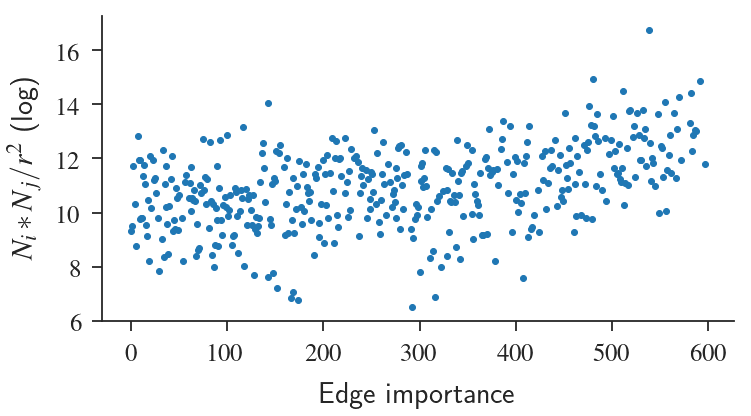

In [113]:
plot_imp_vs_g(bins=10)

In [99]:
plot_imp_vs_g(bins=20)

UnboundLocalError: local variable 'res' referenced before assignment

In [18]:
pop = pd.read_pickle('../data/us_air_mirgration.pkl').to_dict()
def plot_imp_vs_m(bins=50):
    y = []
    for e in data_1[0]:
        a,b = e
        if (a,b) in list(dict_dist.keys()):
            d = dict_dist[(a,b)]
        elif (b,a) in list(dict_dist.keys()):
            d = dict_dist[(b,a)]
        else:
            d = np.nan
        if (a,b) in list(pop.keys()):
            p = pop[(a,b)]
        elif (b,a) in list(pop.keys()):
            p = dict_dist[(b,a)]
        else:
            p = np.nan
        y.append(p/d**2)
    y = np.log(np.array(y))
    y = y[0:bins*(len(y)//bins)]
    y = np.mean(y.reshape(-1, bins), axis=1)
    x = np.arange(len(y))
    fig,ax = plt.subplots(figsize=(xs,ys*0.8))
    plt.scatter(x,y)
    plt.xlabel('Edge importance')
    plt.ylabel('Total Passangers$/r^2$ (log)')
    custom_frame(ax)
    plt.show()

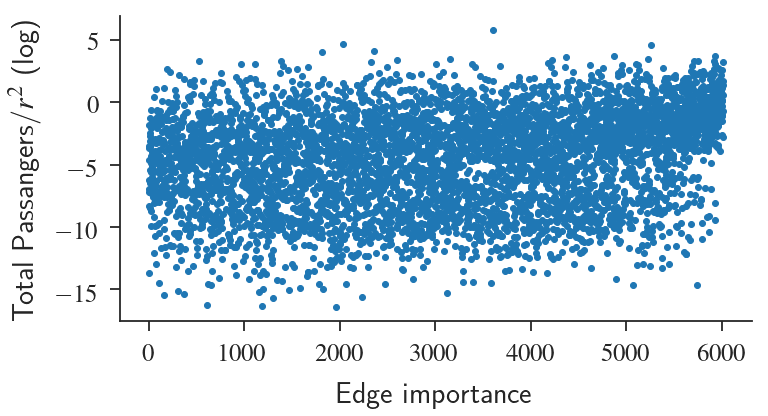

In [24]:
plot_imp_vs_m(bins=1)

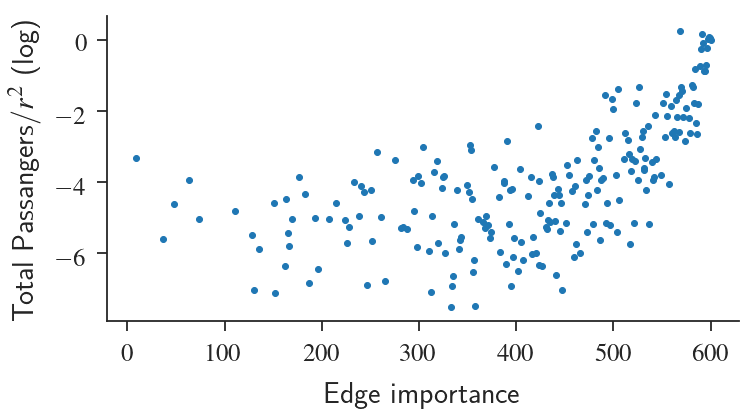

In [25]:
plot_imp_vs_m(bins=10)

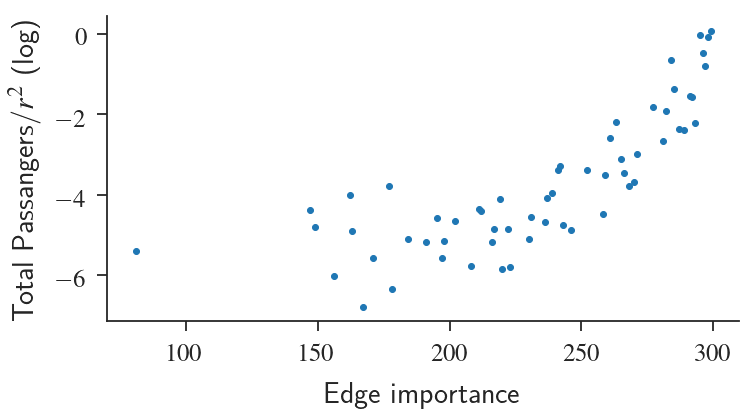

In [26]:
plot_imp_vs_m(bins=20)